In [47]:
# Imports and load data
import tslearn
from aeon.clustering.k_means import TimeSeriesKMeans
from aeon.clustering.k_medoids import TimeSeriesKMedoids
from aeon.clustering.utils.plotting._plot_partitions import plot_cluster_algorithm
from aeon.datasets import load_unit_test

import numpy as np
import matplotlib.pyplot as plt
import neomonkey
neomonkey.installmonkey()
from experiment import Experiment
import matplotlib as mpl
mpl.rcParams['figure.figsize']=(3,2)
import h5py
import ipywidgets as ipyw
from sklearn.preprocessing import MinMaxScaler

In [48]:
def scale(X):
    return MinMaxScaler().fit_transform(X)
def dexp(t_psc,A, tau_1,tau_2):
    tau_1=tau_1 ##*pq.ms,
    tau_2=tau_2 ##*pq.ms,
    Aprime = (tau_2/tau_1)**(tau_1/(tau_1-tau_2))
            #Aprime = (tau_2**(tau_1/(tau_1-tau_2)))/tau_1 ## https://molecularbrain.biomedcentral.com/articles/10.1186/s13041-021-00847-x
    template = A/Aprime * (-np.exp(-t_psc/tau_1) + np.exp((-t_psc/tau_2))) #*int(2*int(p.upward)-1)
    return template

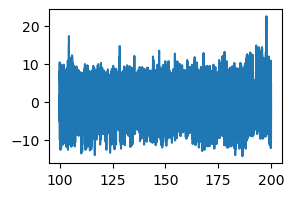

In [49]:
#signal=Experiment("./20211215_85n#4.smr").signal(0,"A")[0]
signal=Experiment("./20190129_35s_syn.smr").signal(0,"A")[0].t(100,200) *-1
plt.plot(signal.s,signal.pA)

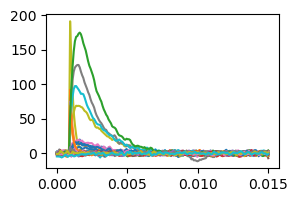

In [50]:
## fetch some "white" noise
import random
#signal=Experiment("./20211215_85n#4.smr").signal(0,"A")[0]
#s=np.concatenate([signal.t(93,101).pA,
#                  signal.t(280,290).pA,
#                  signal.t(292,298).pA,
#                  signal.t(302,318).pA])
s=Experiment("./20211215_85n#4.smr").signal(0,"A")[0].pA
t_psc=np.linspace(0.000,0.015,177)
cnt=100
#amplitudes=np.random.uniform(0,80,cnt)
amplitudes=50*np.random.standard_gamma(0.8,cnt)#np.random.uniform(0,80,cnt)
tau1=np.random.uniform(0.0002,0.0005,cnt)
tau2=np.random.uniform(0.0010,0.002,cnt)
onoff=np.random.choice([True,False],cnt)
onsets=np.random.randint(0,len(s)-177,cnt)
X_fake=[]
y_fake=[]
for a,t1,t2,y,o in zip(amplitudes,tau1,tau2,onoff,onsets):
    a_psc=y*np.roll(dexp(t_psc,a,t1,t2),10)
    a_psc+=s[o:o+177]#]np.random.choice(s,177)
    X_fake.append(a_psc)
    y_fake.append(y)

amplitudes=50*np.random.standard_gamma(0.8,cnt)#np.random.uniform(0,80,cnt)
tau1=np.random.uniform(0.00002,0.00004,cnt) ## ultra sharps should be rejected
tau2=np.random.uniform(0.00010,0.0002,cnt)  ## ultra sharps
onoff=np.random.choice([True,False],cnt)
onsets=np.random.randint(0,len(s)-177,cnt)
for a,t1,t2,y,o in zip(amplitudes,tau1,tau2,onoff,onsets):
    a_psc=y*np.roll(dexp(t_psc,a,t1,t2),10)
    a_psc+=s[o:o+177]#]np.random.choice(s,177)
    X_fake.append(a_psc)
    y_fake.append(y*0)
p = np.random.permutation(len(X_fake))
X_fake=np.array(X_fake)[p]
y_fake=np.array(y_fake)[p]
for e in X_fake[:50]:
    plt.plot(t_psc,e)

In [51]:
with h5py.File('20211215_85n#4.hdf5', 'r') as f:
    X_data1=f[list(f.keys())[0]][:]
    y_data1=f[list(f.keys())[1]][:]
with h5py.File("20211215_85n#1.hdf5", 'r') as f:
    X_data2=f[list(f.keys())[0]][:]
    y_data2=f[list(f.keys())[1]][:]
with h5py.File("20211110_103s.hdf5", 'r') as f:
    X_data3=f[list(f.keys())[0]][:]
    y_data3=f[list(f.keys())[1]][:]

In [52]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(np.array(X_fake),
                                               np.array(y_fake),
                                               test_size=0.25)

In [53]:
X_train=X_data3
y_train=y_data3

In [54]:
nclust=5
scale = lambda X:MinMaxScaler().fit_transform(X)
#scale = lambda X:X
method='kmedoids'
if method=='kmeans': ## kmeans
    classifier = TimeSeriesKMeans(
    n_clusters=nclust,  # Number of desired centers
    init_algorithm="random",  # Center initialisation technique
    max_iter=10,  # Maximum number of iterations for refinement on training set
    metric="msm",  # Distance metric to use "dtw","msm"
    averaging_method="ba",  # Averaging technique to use "ba","mean"
    random_state=42,
    average_params={
        "metric": "msm",
        },
    )
elif method=='kmedoids': ## kmedoids
    classifier = TimeSeriesKMedoids(
    n_clusters=nclust,  # Number of desired centers
    init_algorithm="random",  # Center initialisation technique
    max_iter=10,  # Maximum number of iterations for refinement on training set
    verbose=False,  # Verbose
    method = 'alternate', ## faster
    distance="msm",  # Distance to use
    random_state=1,
    )
elif method=='deepkmeans':
    from deeptime.clustering import KMeans
    classifier = KMeans(
        n_clusters=nclust,  # place 100 cluster centers
        init_strategy='uniform',  # uniform initialization strategy
        max_iter=10,  # don't actually perform the optimization, just place centers
        fixed_seed=13,
        n_jobs=14,
    )
classifier.fit(scale(X_train))
print()

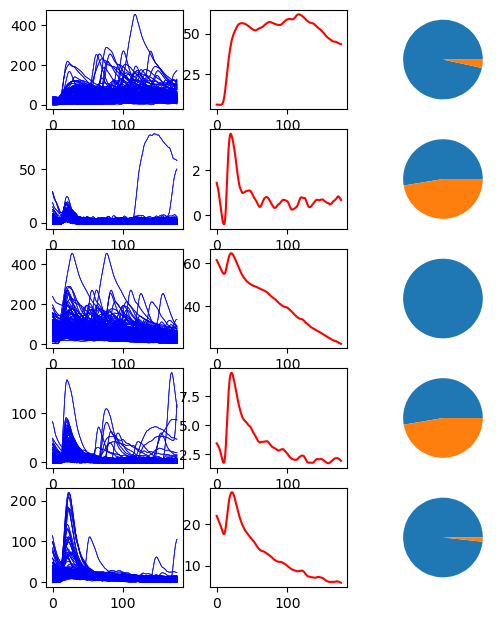

In [55]:
try:
    results=k_means.predict(scale(X_train))
except:
    results=k_means.fetch_model().transform(scale(X_train))
mpl.rcParams['figure.figsize']=(6,nclust*1.5)
fig, axes=plt.subplots(nclust,3)
for c in range(nclust):
    for idx,x in enumerate(X_train):
        axes[results[idx]][0].plot(x,'b',lw=0.5,alpha=0.5)
    if np.sum(results==c): ## if we have at least one trace
        avg=np.mean(X_train[results==c],axis=0)
        axes[c][1].plot(avg,'r')
        axes[c][2].pie([np.sum(y_train[results==c]),np.sum(1-y_train[results==c])])